In [11]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy
# from linescanning import plotting
from ipywidgets import *
import matplotlib.pyplot as plt
import yaml
from AF_sims_utils import *
import pickle

from skimage import data

with open('settings.yml', 'r') as f:
    settings=yaml.safe_load(f)

%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# AF Model

In [12]:


roi_sizevecc={
    'v1': [0.13385682, 0.32001923],
    'v2': [0.15729394, 0.41346214],
    'v3': [0.20515842, 0.50832351],
    'hv4': [0.27438712, 0.65617198],
    'v3ab': [0.31960992, 0.92485069],
    'LO': [0.50756658, 0.7126011 ],
    'VO': [0.4291982,  0.98426316],
    'VO': [0.4291982,  0.98426316],
    'LO': [0.50756658, 0.7126011 ],
    'v3ab': [0.31960992, 0.92485069],
    'TO': [0.69433333, 1.35400283],
    'IPS': [0.56945639, 0.94961559]}

# 'LowerIPS': [0.50802712, 0.95748107],
# 'UpperIPS': [0.68450644, 0.87478754]

# szvecc=np.load('sizevecc_fits.pkl',allow_pickle=True)
# szvecc['sub-001']

/Users/sumiyaabdirashid/Desktop/PhD/code/pRF_sims/AF_sims_utils.py:528: RuntimeWarning: Mean of empty slice
  binned=[func(data[(binon >= bins[i])&(binon<bins[i+1])]) for i in range(len(bins)-1)]


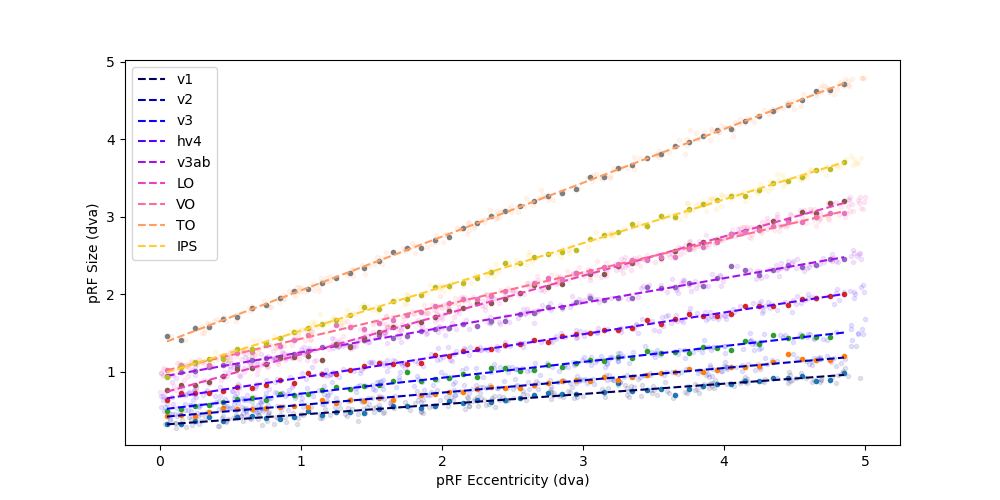

In [13]:
b=np.arange(0,5,0.1)
x=np.asarray([(b[i]+b[i+1])/2 for i in range(len(b)-1)])
simsize=True # whether to simulate size or use data values
func=np.nanmean if simsize else np.nanmedian

if simsize:
    n=200
    sd=0.05
    rng=np.random.default_rng(42)
    ecc=rng.random((len(roi_sizevecc.keys()),n))*5
    size=[]

fig,ax=plt.subplots(1,1,figsize=(10,5))
sub='sub-011'

for i,roi in enumerate(roi_sizevecc.keys()):
    if simsize:
        p=roi_sizevecc[roi]
        tmpsize=np.asarray([rng.normal(v,sd) for v in ecc[i]*p[0] +p[1]]) # use line to estimate size, add some gaussian noise
        tmpsize=np.where(tmpsize>=0,tmpsize,np.nan)
        idx=np.isfinite(tmpsize) # remove negative sizes, sd is low to prevent too many
        size.append(tmpsize)
    else:
        tmpsize=size[i]
        idx=np.isfinite(tmpsize)

    p2=np.polyfit(ecc[i][idx],tmpsize[idx],1) # fit a line to the simulated data
    ax.plot(ecc[i][idx],tmpsize[idx],'.',c=settings['cmap'][roi],alpha=0.1) # plot the simulated data
    ax.plot(x,return_binned(tmpsize[idx],ecc[i][idx],list(b),func=np.nanmean),'.') #plot binned simulated data
    ax.plot(x,x*p2[0]+p2[1],c=settings['cmap'][roi],linestyle='dashed',label=roi) # plot sim size ecc line
    # ax.plot(x,x*p[0]+p[1],c=settings['cmap'][roi]) # actual size ecc line from data

plt.ylabel('pRF Size (dva)')
plt.xlabel('pRF Eccentricity (dva)')
plt.legend()
plt.show()

size=np.asarray(size)

# 1+ AF

interactive(children=(FloatSlider(value=0.4, description='sigAF1', max=20.0, min=0.1), FloatSlider(value=3.3, …

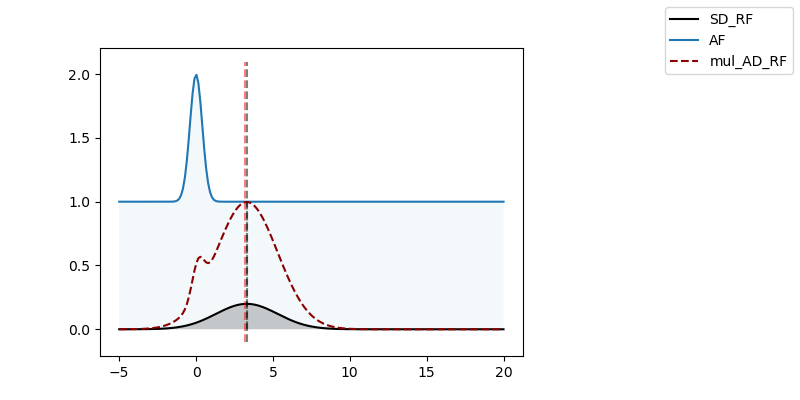

In [14]:
bins = 200
r=20
b=np.linspace(-r/4,r,bins)

# attention field & pRF params
mupRF= 3.3
sigRF= 2
muAF= 0
sigAF1=0.4
sigAF2=3.3

# formatting
shadeSD=True
shadeAF=True

mu_final,sig_final=gauss_interaction(mupRF,sigpRF,muAF,sigAF1)
scaling=fit_gauss(mu_final,sig_final,b).sum()/(fit_gauss(muAF,sigAF1,b)*fit_gauss(mupRF,sigpRF,b)).sum()

fig, axs = plt.subplots(1,2,figsize=(8,4),gridspec_kw={'width_ratios': [3, 1]})

sigAF1,sigAF2,mupRF,sigpRF,sigpRF2,scaling,offset = widgets.FloatSlider(sigAF1,min=0.1,max=20),\
                                                    widgets.FloatSlider(sigAF2,min=0.1,max=20),\
                                                    widgets.FloatSlider(mupRF,min=0,max=10),\
                                                    widgets.FloatSlider(sigpRF,min=0.5,max=10),\
                                                    widgets.FloatSlider(sigpRF+1,min=0.5,max=10),\
                                                    widgets.IntSlider(1,min=1,max=100),\
                                                    widgets.FloatSlider(1,min=0,max=10)

def update_hist(sigAF1,sigAF2,mupRF,sigpRF,offset,scaling):
    axs[0].clear()
    ylim=axs[0].get_ylim()

    mu_final,sig_final=gauss_interaction(mupRF,sigpRF,muAF,sigAF1)

    ### Vanilla Gaussian Attention Field Model ###
    ##############################################
    axs[0].plot(b,(fit_gauss(mupRF,sigpRF,b)),'black',label='SD_RF')
    axs[0].vlines(mupRF,*ylim,'black','dashed',alpha=0.5)

    if shadeSD:
        axs[0].fill_between(b,(fit_gauss(mupRF,sigpRF,b)),fc='black',alpha=0.2) # shading for SD-RF
    # axs[0].plot(b,fit_gauss(muAF,sigAF1,b), '-',label='AF')
    # axs[0].plot(b,fit_gauss(mu_final,sig_final,b),zorder=0,label='AD_RF')

    ### Adding offset to Attention field ###
    ########################################
    axs[0].plot(b,offset+1*fit_gauss(muAF,sigAF1,b), '-',label='AF')
    if shadeAF:
        axs[0].fill_between(b,offset+1*fit_gauss(muAF,sigAF1,b),alpha=0.05) 

    mu,sig=gaus_attn(mupRF,sigpRF,muAF,sigAF1,offset,scalingSD=scaling,x=b)
    mu0,sig0=gaus_attn(mupRF,sigpRF,muAF,sigAF1,1,1,x=b)

    # axs[0].plot(b,fit_gauss(mu,sig,bins=b),'--',c='red',label='AD_RF') # gaus_attn func
    axs[0].plot(b,(scaling*fit_gauss(mupRF,sigpRF,b))*5*(offset+1*fit_gauss(muAF,sigAF1,b)),'--', c='darkred',label='mul_AD_RF') # direct multiplication
    ylim=axs[0].get_ylim()
    axs[0].vlines(mu,*ylim,'red','dashed',alpha=0.5)
    axs[0].vlines(mupRF,*ylim,'black','dashed',alpha=0.5)
    print(mupRF-mu)

    # axs[0].annotate('mupRF',(mupRF+2,ylim[1]-(ylim[1]/10)),ha='center')
    # axs[0].annotate('mu\nAD-pRF',(mu-2,ylim[1]-(ylim[1]/10)),ha='center')

    ### DoG Attention Field ###
    ############################
    # axs[0].plot(b,(offset+fit_gauss(muAF,sigAF1,b)-fit_gauss(muAF,sigAF2,b)), '--',label='DoG_AF') 
    # axs[0].plot(b,fit_gauss(muAF,sigAF1,b), '--',label='AF1') # Gaussian that makes up positive part
    # axs[0].plot(b,-fit_gauss(muAF,sigAF2,b), '--',label='-AF2') # Gaussian that makes up inhibitory surround 
    # muDoG,sigDoG=DoG_attn(mupRF,sigpRF,muAF,[sigAF1,sigAF2],offset,x=b)
    # axs[0].plot(b,fit_gauss(*DoG_attn(mupRF,sigpRF,muAF,[sigAF1,sigAF2],offset,x=b),bins=b), '--',c='red',label='DoGAF*SD_RF')
    # axs[0].vlines(muDoG,*ylim,'red','dashed',alpha=0.5)
    
    ### DoG Func Sanity Checks ###
        # axs[0].plot(b,(fit_gauss(mupRF,sigpRF,b)*(offset+fit_gauss(muAF,sigAF1,b)-fit_gauss(muAF,sigAF2,b))), '--',label='DoGAF*SD_RF')
        # popt,_=scipy.optimize.curve_fit(fit_gauss,b,(fit_gauss(mupRF,sigpRF,b)*(offset+fit_gauss(muAF,sigAF1,b)-fit_gauss(muAF,sigAF2,b))))
        # axs[0].plot(b,fit_gauss(popt[1],popt[0],bins=b), '--',label='DoGAF*SD_RF')
        # print(popt)
    
    ### Norm pRF X Attention Field ###
    ###################################

    # axs[0].plot(b,(fit_gauss(mupRF,sigpRF2,b)),label='SD_RF2')
    # axs[0].plot(b,fit_gauss(mupRF,sigpRF,b)/fit_gauss(mupRF,sigpRF2,b),label='pRF_SD1/SD2')
    # axs[0].plot(b,(fit_gauss(mupRF,sigpRF,b)/fit_gauss(mupRF,sigpRF2,b))*(offset+fit_gauss(muAF,sigAF1,b)),label='AD_normRFxAF')
    # axs[0].plot(b,fit_gauss(*gaus_attn(mupRF,sigpRF,muAF,sigAF1,offset,x=b,sigSD2=sigpRF2),bins=b),'--',c='red',label='AD_RF') # gaus_attn func


    ### Norm pRF X DoG Attention Field ###
    ###################################
    # popt,_=scipy.optimize.curve_fit(fit_gauss,b,fit_gauss(mupRF,sigpRF,b)/fit_gauss(mupRF,sigpRF2,b)*(offset+fit_gauss(muAF,sigAF1,b)-fit_gauss(muAF,sigAF2,b)))
    # axs[0].plot(b,fit_gauss(popt[1],popt[0],bins=b), '--',label='normRF*DoGAF')
    # print(popt)


    # axs[0].set_xlim(-1,3)
    # axs[0].set_ylim(0,2)
    fig.legend()

fig.delaxes(axs[1]) 
_=interact(update_hist,
        sigAF1=sigAF1,
        sigAF2=sigAF2,
        mupRF=mupRF,
        sigpRF=sigpRF,
        sigpRF2=sigpRF2,
        offset=offset,
        scaling=scaling
    )

In [ ]:
# set up the figure
bins = 200
r=20
b=np.linspace(-r/4,r,bins)

# SD pRF params
muRF= 3.3 
sigpRF= 2
sigpRF2=0, #for DoG R
offsetRF=0
scalingRF=1

# attention field params
muAF= 0
sigAF1=0.4
sigAF2=0, #for DoG A
offsetAF=1
scalingAF=1

# formatting
shadeSD=True
shadeAF=True

# initial plot: calculate attention-driven RF
mu_final,sig_final=gauss_interaction(muRF,sigpRF,muAF,sigAF1)
# scaling=fit_gauss(mu_final,sig_final,b).sum()/(fit_gauss(muAF,sigAF1,b)*fit_gauss(muRF,sigpRF,b)).sum()

fig, axs = plt.subplots(1,2,figsize=(8,4),gridspec_kw={'width_ratios': [3, 1]})

In [20]:
bins = 200
r=20
b=np.linspace(-r/4,r,bins)

# SD pRF params
muRF= 3.3 
sigRF= 2
sigRF2=0, #for DoG R
offsetRF=0
scalingRF=1

# 
muAF= 0
sigAF1=0.4
sigAF2=0, #for DoG A
offset=1
scalingAF=1



# formatting
shadeSD=True
shadeAF=True

mu_final,sig_final=gauss_interaction(muRF,sigRF,muAF,sigAF1)
scaling=fit_gauss(mu_final,sig_final,b).sum()/(fit_gauss(muAF,sigAF1,b)*fit_gauss(muRF,sigRF,b)).sum()

fig, axs = plt.subplots(1,2,figsize=(8,4),gridspec_kw={'width_ratios': [3, 1]})

pars=[sigAF1,sigAF2,offset,scalingAF,muRF,sigRF,sigRF2,offsetRF,scalingRF]
par_name=[sigAF1,sigAF2,offset,scalingAF,muRF,sigRF,sigRF2,offsetRF,scalingRF]

{widgets.FloatSlider(p,min=0.1,max=) for p in pars}

sigAF1,sigAF2,sigRF,sigRF2 = 
muRF=
offsetAF,offsetRF=
scalingAF,scalingRF=

sigAF1,sigAF2,muRF,sigpRF,sigpRF2,scaling,offset = widgets.FloatSlider(sigAF1,min=0.1,max=20),\
                                                    widgets.FloatSlider(sigAF2,min=0.1,max=20),\
                                                    widgets.FloatSlider(muRF,min=0,max=10),\
                                                    widgets.FloatSlider(sigpRF,min=0.5,max=10),\
                                                    widgets.FloatSlider(sigpRF+1,min=0.5,max=10),\
                                                    widgets.IntSlider(1,min=1,max=100),\
                                                    widgets.FloatSlider(1,min=0,max=10)

def update_hist(sigAF1,sigAF2,muRF,sigpRF,offset,scaling):
    axs[0].clear()
    ylim=axs[0].get_ylim()

    mu_final,sig_final=gauss_interaction(muRF,sigpRF,muAF,sigAF1)

    ### Vanilla Gaussian Attention Field Model ###
    ##############################################
    axs[0].plot(b,(fit_gauss(muRF,sigpRF,b)),'black',label='SD_RF')
    axs[0].vlines(muRF,*ylim,'black','dashed',alpha=0.5)

    if shadeSD:
        axs[0].fill_between(b,(fit_gauss(muRF,sigpRF,b)),fc='black',alpha=0.2) # shading for SD-RF
    # axs[0].plot(b,fit_gauss(muAF,sigAF1,b), '-',label='AF')
    # axs[0].plot(b,fit_gauss(mu_final,sig_final,b),zorder=0,label='AD_RF')

    ### Adding offset to Attention field ###
    ########################################
    axs[0].plot(b,offset+1*fit_gauss(muAF,sigAF1,b), '-',label='AF')
    if shadeAF:
        axs[0].fill_between(b,offset+1*fit_gauss(muAF,sigAF1,b),alpha=0.05) 

    mu,sig=gaus_attn(muRF,sigpRF,muAF,sigAF1,offset,scalingRF=scaling,x=b)
    mu0,sig0=gaus_attn(muRF,sigpRF,muAF,sigAF1,1,1,x=b)

    # axs[0].plot(b,fit_gauss(mu,sig,bins=b),'--',c='red',label='AD_RF') # gaus_attn func
    axs[0].plot(b,(scaling*fit_gauss(muRF,sigpRF,b))*5*(offset+1*fit_gauss(muAF,sigAF1,b)),'--', c='darkred',label='mul_AD_RF') # direct multiplication
    ylim=axs[0].get_ylim()
    axs[0].vlines(mu,*ylim,'red','dashed',alpha=0.5)
    axs[0].vlines(muRF,*ylim,'black','dashed',alpha=0.5)

    # axs[0].annotate('muRF',(muRF+2,ylim[1]-(ylim[1]/10)),ha='center')
    # axs[0].annotate('mu\nAD-pRF',(mu-2,ylim[1]-(ylim[1]/10)),ha='center')

    ### DoG Attention Field ###
    ############################
    # axs[0].plot(b,(offset+fit_gauss(muAF,sigAF1,b)-fit_gauss(muAF,sigAF2,b)), '--',label='DoG_AF') 
    # axs[0].plot(b,fit_gauss(muAF,sigAF1,b), '--',label='AF1') # Gaussian that makes up positive part
    # axs[0].plot(b,-fit_gauss(muAF,sigAF2,b), '--',label='-AF2') # Gaussian that makes up inhibitory surround 
    # muDoG,sigDoG=DoG_attn(muRF,sigpRF,muAF,[sigAF1,sigAF2],offset,x=b)
    # axs[0].plot(b,fit_gauss(*DoG_attn(muRF,sigpRF,muAF,[sigAF1,sigAF2],offset,x=b),bins=b), '--',c='red',label='DoGAF*SD_RF')
    # axs[0].vlines(muDoG,*ylim,'red','dashed',alpha=0.5)
    
    ### DoG Func Sanity Checks ###
        # axs[0].plot(b,(fit_gauss(muRF,sigpRF,b)*(offset+fit_gauss(muAF,sigAF1,b)-fit_gauss(muAF,sigAF2,b))), '--',label='DoGAF*SD_RF')
        # popt,_=scipy.optimize.curve_fit(fit_gauss,b,(fit_gauss(muRF,sigpRF,b)*(offset+fit_gauss(muAF,sigAF1,b)-fit_gauss(muAF,sigAF2,b))))
        # axs[0].plot(b,fit_gauss(popt[1],popt[0],bins=b), '--',label='DoGAF*SD_RF')
        # print(popt)
    
    ### Norm pRF X Attention Field ###
    ###################################

    # axs[0].plot(b,(fit_gauss(muRF,sigpRF2,b)),label='SD_RF2')
    # axs[0].plot(b,fit_gauss(muRF,sigpRF,b)/fit_gauss(muRF,sigpRF2,b),label='pRF_SD1/SD2')
    # axs[0].plot(b,(fit_gauss(muRF,sigpRF,b)/fit_gauss(muRF,sigpRF2,b))*(offset+fit_gauss(muAF,sigAF1,b)),label='AD_normRFxAF')
    # axs[0].plot(b,fit_gauss(*gaus_attn(muRF,sigpRF,muAF,sigAF1,offset,x=b,sigSD2=sigpRF2),bins=b),'--',c='red',label='AD_RF') # gaus_attn func


    ### Norm pRF X DoG Attention Field ###
    ###################################
    # popt,_=scipy.optimize.curve_fit(fit_gauss,b,fit_gauss(muRF,sigpRF,b)/fit_gauss(muRF,sigpRF2,b)*(offset+fit_gauss(muAF,sigAF1,b)-fit_gauss(muAF,sigAF2,b)))
    # axs[0].plot(b,fit_gauss(popt[1],popt[0],bins=b), '--',label='normRF*DoGAF')
    # print(popt)


    # axs[0].set_xlim(-1,3)
    # axs[0].set_ylim(0,2)
    fig.legend()

fig.delaxes(axs[1]) 
_=interact(update_hist,
        sigAF1=sigAF1,
        sigAF2=sigAF2, #for DoG AF
        offsetAF=offsetAF,
        scalingAF=scalingAF,
        muRF=muRF,
        sigRF=sigpRF,
        sigRF2=sigpRF2, #for DoG RF
        offsetRF=offsetRF,
        scalingRF=scalingRF
    )

SyntaxError: invalid syntax (2097746407.py, line 32)

# Testing AF models for AF-size data

/Users/sumiyaabdirashid/Desktop/PhD/code/pRF_sims/AF_sims_utils.py:530: RuntimeWarning: Mean of empty slice
  binned=[np.nanmean(data[(binon >= bins[i])&(binon<bins[i+1])]) for i in range(len(bins)-1)]


interactive(children=(FloatSlider(value=1.0, description='AFS', max=50.0, min=0.1), FloatSlider(value=10.0, de…

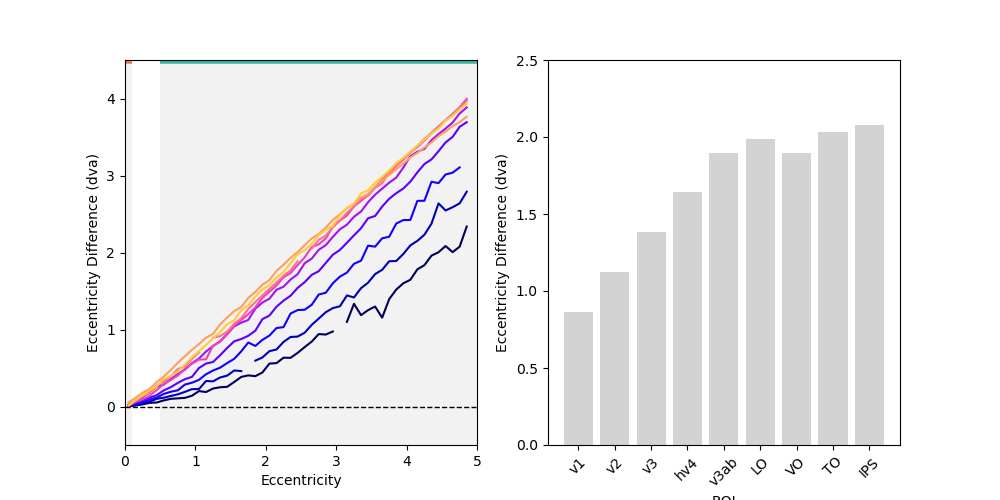

In [6]:
b=np.arange(0,5,0.1)
xline=[(b[i]+b[i+1])/2 for i in range(len(b)-1)]
xbar=np.arange(len(roi_sizevecc.keys()))

startS,startL=1,10
afS,afL = widgets.FloatSlider(startS,min=0.1,max=50),widgets.FloatSlider(startL,min=0.1,max=100)
plt.ion()

figure,axs=plt.subplots(1,2,figsize=(10,5))

lines =[]
for i,roi in enumerate(roi_sizevecc.keys()):
    ylines=return_binned(gauss_interaction(ecc[i],size[i],0,startL)[0]-gauss_interaction(ecc[i],size[i],0,startS)[0],ecc[i],list(b))
    # ylines=return_binned(gauss_interaction(ecc[i],size[i],0,startL)[0]-gauss_interaction(ecc[i],size[i],0,startS)[0],gauss_interaction(ecc[i],size[i],0,startL)[0],list(b))
    ybar=np.nanmean(gauss_interaction(ecc[i],size[i],0,startL)[0]-gauss_interaction(ecc[i],size[i],0,startS)[0])
    lines.append(axs[0].plot(xline,ylines,color=settings['cmap'][roi],label=roi))
rects=axs[1].bar(xbar,ybar,color='lightgray')


axs[0].set_ylabel('Eccentricity Difference (dva)')
axs[0].set_xlabel('Eccentricity')
axs[0].set_xlim(0,5)
axs[0].set_ylim(-0.5,4.5)
axs[1].set_ylabel('Eccentricity Difference (dva)')
axs[1].set_xlabel('ROI')
axs[1].set_ylim(0,2.5)
ylim=axs[0].get_ylim()[1]


axs[0].fill_between([0,0.1],[-ylim,-ylim],[ylim,ylim],alpha=0.1,color='gray',zorder=0,linewidth=0)
axs[0].fill_between([0.5,5],[-ylim,-ylim],[ylim,ylim],alpha=0.1,color='gray',zorder=0,linewidth=0)
axs[0].hlines(ylim-0.01,0,0.1,'black','solid',lw=4,color=settings.get('cmap').get('small'))
axs[0].hlines(ylim-0.01,0.5,5,'black','solid',lw=4,color=settings.get('cmap').get('large'))


def sub_eccs(AFS, AFL):
    axs[0].hlines(0,0,5,'black','dashed',lw=1)
    for i,roi,line,rect in zip(np.arange(10),roi_sizevecc.keys(),lines,rects):
        line=line[0]
        line.set_ydata(return_binned(gauss_interaction(ecc[i],size[i],0,AFL)[0]-gauss_interaction(ecc[i],size[i],0,AFS)[0],ecc[i],list(b),func=func))
        line.set_color(settings['cmap'][roi])
        rect.set_height(np.nanmean(gauss_interaction(ecc[i],size[i],0,AFL)[0]-gauss_interaction(ecc[i],size[i],0,AFS)[0]))
    axs[1].set_xticks(np.arange(len(roi_sizevecc.keys())),roi_sizevecc.keys(),rotation=45)
    

fig.tight_layout()    
fig.legend()

_=interact(sub_eccs,
    AFS=afS,
    AFL=afL
    )

interactive(children=(FloatSlider(value=0.1, description='AFS', max=25.0, min=0.1), FloatSlider(value=10.0, de…

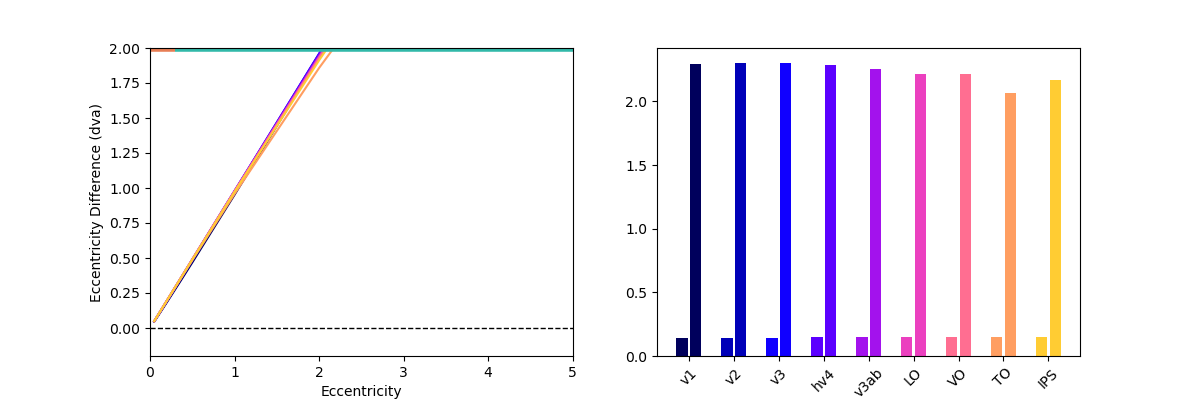

In [13]:
par='ecc'
parid = 1 if par == 'size' else 0

ecc=np.asarray([0.05,0.1,0.15,0.2,0.25,0.35,0.5,1,2,3,3.5,4,4.5])
p=roi_sizevecc

attn_func=gaus_attn
b=np.arange(0,5,0.1)
xline=ecc #[(b[i]+b[i+1])/2 for i in range(len(b)-1)]
xbar=np.arange(0,len(roi_sizevecc.keys()),0.5)
rois=[*roi_sizevecc]
sizes=np.asarray([ecc*roi_sizevecc[roi][0]+roi_sizevecc[roi][1] for roi in rois])
# sizes=np.ones(sizes.shape)

startS,startL=0.1,10
afS,afL,offsetS,offsetL,RF_ampS,RF_ampL = widgets.FloatSlider(startS,min=0.1,max=25),\
                                                    widgets.FloatSlider(startL,min=0.1,max=100),\
                                                    widgets.FloatSlider(1,min=0,max=100),\
                                                    widgets.FloatSlider(1,min=0,max=100),\
                                                    widgets.FloatSlider(1,min=1,max=20),\
                                                    widgets.FloatSlider(1,min=1,max=20)
plt.ion()
figure,axs=plt.subplots(1,2,figsize=(12,4),gridspec_kw={'width_ratios': [1,1],'wspace':0.2})

# roi_lines =[]
lines =[]
for ix,roi in enumerate(rois):
    # if roi != 'v1':
    #     continue
    yline=attn_func(ecc,sizes[ix],0,startL)[parid]-attn_func(ecc,sizes[ix],0,startS)[parid]
    ybar=np.nanmean(attn_func(ecc,sizes[ix],0,startL)[parid]-attn_func(ecc,sizes[ix],0,startS)[parid])
    ybar=np.ones(len(xbar))
    lines.append(axs[0].plot(xline,yline,color=settings['cmap'][roi],label=roi))
rects=axs[1].bar(xbar,ybar,width=0.25,color='lightgray')

axs[0].set_ylabel('Eccentricity Difference (dva)')
axs[1].set_ylabel('Eccentricity Difference (dva)')

axs[0].set_xlabel('Eccentricity')
axs[0].hlines(0,0,5,'black','dashed',lw=1)
axs[0].set_xlim(0,5)
axs[0].set_ylim(-0.2,2)
ylim=axs[0].get_ylim()[1]

# axs[0].fill_between([0,0.3],[-ylim,-ylim],[ylim,ylim],alpha=0.1,color='gray',zorder=0,linewidth=0)
# axs[0].fill_between([0.3,5],[-ylim,-ylim],[ylim,ylim],alpha=0.1,color='gray',zorder=0,linewidth=0)
axs[0].hlines(ylim-0.01,0,0.3,'black','solid',lw=4,color=settings.get('cmap').get('small'))
axs[0].hlines(ylim-0.01,0.3,5,'black','solid',lw=4,color=settings.get('cmap').get('large'))

def update_plots(AFS, AFL,ampL,ampS):
    offsetS=0
    offsetL=0
    amp_rngS=[0,0.2]
    amp_rngL=[0.5,5]

    xs=np.arange(0,len(roi_sizevecc.keys()),0.5)
    xs=np.where(xs%1==0,xs,xs-0.2)
    xbar=[xs[i:i+2] for i in range(len(xs)) if i%2 ==0]
    axs[1].clear()

    for ix,roi in enumerate(rois):
        # if roi != 'v1':
        #     continue
        size=sizes[ix]
        for line,rect in zip(lines[ix],rects):
            ylines=attn_func(ecc,size,0,AFL,offsetL,ampL,amp_rngL)[parid]-attn_func(ecc,size,0,AFS,offsetS,ampS,amp_rngS)[parid]
            # line=line[0]
            line.set_ydata(ylines)
            line.set_color(settings['cmap'][roi])
            # rect.set_height()
        axs[1].bar(xbar[ix],
                [np.mean((attn_func(ecc,size,0,AFL,offsetL,ampL,amp_rngL)[parid]-attn_func(ecc,size,0,AFS,offsetS,ampS,amp_rngS)[parid])[ecc < 0.3]),
                np.mean((attn_func(ecc,size,0,AFL,offsetL,ampL,amp_rngL)[parid]-attn_func(ecc,size,0,AFS,offsetS,ampS,amp_rngS)[parid])[ecc >= 0.3])],
                width=0.25,color=settings['cmap'][roi])
    
    axs[1].set_xticks([xbar[i].mean() for i in range(len(xbar))],rois,rotation=45)

fig.tight_layout()
fig.legend()

_=interact(update_plots,
    AFS=afS,
    AFL=afL,
    ampL=RF_ampL,
    ampS=RF_ampS)


interactive(children=(FloatSlider(value=0.25, description='AFS', max=10.0, min=0.1), FloatSlider(value=15.0, d…

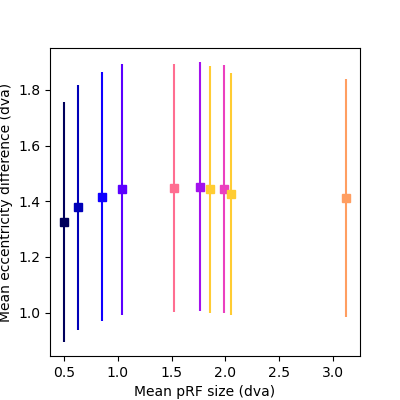

In [66]:
par='ecc'
parid = 1 if par == 'size' else 0

startS,startL=0.25,15
fig,axs=plt.subplots(1,1,figsize=(4,4))

AFS,AFL = widgets.FloatSlider(startS,min=0.1,max=10),\
            widgets.FloatSlider(startL,min=0.1,max=100)

def update_plot(AFS,AFL):
    axs.clear()
    for ix,roi in enumerate(rois):
        axs.errorbar(np.mean(size[ix]),
                    np.mean(attn_func(ecc,sizes[ix],0,AFL,offset=0)[parid]-attn_func(ecc,sizes[ix],0,AFS,offset=0)[parid]),
                    yerr=scipy.stats.sem(attn_func(ecc,sizes[ix],0,AFL,offset=0)[parid]-attn_func(ecc,sizes[ix],0,AFS,offset=0)[parid]),
                    fmt='s',label=roi,
                    color=settings['cmap'][roi])
        axs.set_ylabel('Mean eccentricity difference (dva)')
        axs.set_xlabel('Mean pRF size (dva)')

_=interact(update_plot,
    AFS=AFS,
    AFL=AFL)


### Gaus Attn w/ Offset

In [7]:
ecc=np.linspace(1,6,20)

/Users/sumiyaabdirashid/miniconda3/envs/cortexenv/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


interactive(children=(FloatSlider(value=0.6, description='AFS', max=10.0, min=0.1), FloatSlider(value=1.0, des…

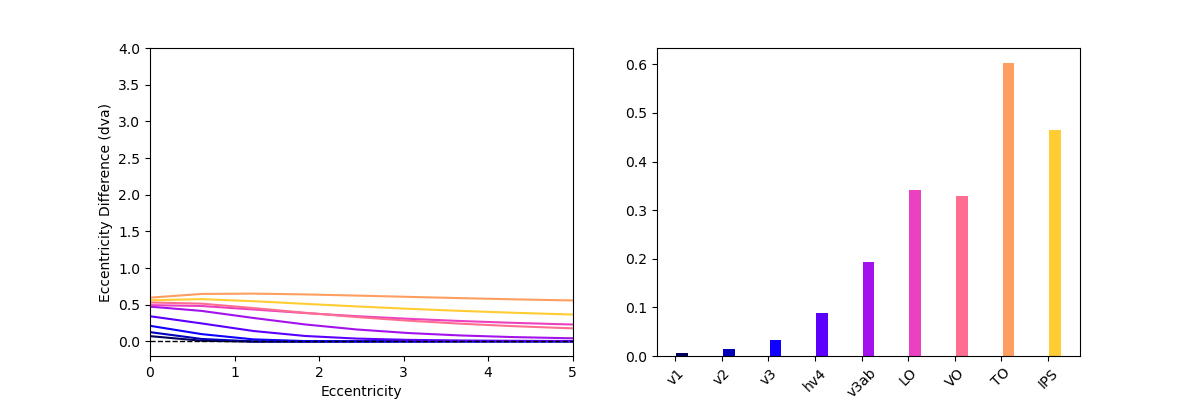

In [120]:
par='ecc'
parid = 1 if par == 'size' else 0

ecc=np.asarray([0.05,0.1,0.15,0.2,0.25,0.35,0.5,1,2,3,3.5,4,4.5])
ecc=np.linspace(1.5,7,10)

p=roi_sizevecc

attn_func=gaus_attn
b=np.arange(0,5,0.1)
xline=ecc #[(b[i]+b[i+1])/2 for i in range(len(b)-1)]
xbar=np.arange(0,len(roi_sizevecc.keys()),0.5)
rois=[*roi_sizevecc]
sizes=np.asarray([ecc*roi_sizevecc[roi][0]+roi_sizevecc[roi][1] for roi in rois])

startS,startL=0.6,1
afS,afL,offsetS,offsetL,ampL,ampS = widgets.FloatSlider(startS,min=0.1,max=10),\
                                                    widgets.FloatSlider(startL,min=0.1,max=100),\
                                                    widgets.FloatSlider(1,min=0,max=100),\
                                                    widgets.FloatSlider(1,min=0,max=100),\
                                                    widgets.FloatSlider(0.5,min=-1,max=20),\
                                                    widgets.FloatSlider(2,min=0,max=20)
plt.ion()
figure,axs=plt.subplots(1,2,figsize=(12,4),gridspec_kw={'width_ratios': [1,1],'wspace':0.2})

# roi_lines =[]
lines =[]
for ix,roi in enumerate(rois):
    yline=attn_func(ecc,sizes[ix],0,startL)[parid]-attn_func(ecc,sizes[ix],0,startS)[parid]
    ybar=np.nanmean(attn_func(ecc,sizes[ix],0,startL)[parid]-attn_func(ecc,sizes[ix],0,startS)[parid])
    ybar=np.ones(len(xbar))
    lines.append(axs[0].plot(xline-ecc[0],yline,color=settings['cmap'][roi],label=roi))
rects=axs[1].bar(xbar,ybar,width=0.25,color='lightgray')

axs[0].set_ylabel('Eccentricity Difference (dva)')
axs[1].set_ylabel('Eccentricity Difference (dva)')

axs[0].set_xlabel('Eccentricity')
axs[0].hlines(0,0,5,'black','dashed',lw=1)
axs[0].set_xlim(0,5)


def update_plots(AFS, AFL,ampS,ampL):
    offsetS=1
    offsetL=1

    xs=np.arange(0,len(roi_sizevecc.keys()),0.5)
    xs=np.where(xs%1==0,xs,xs-0.2)
    xbar=[xs[i:i+2] for i in range(len(xs)) if i%2 ==0]
    axs[1].clear()

    for ix,roi in enumerate(rois):
        size=sizes[ix]
        for line,rect in zip(lines[ix],rects):
            ylines=attn_func(ecc,size,0,AFL,offsetL,scalingAF=ampL)[parid]-attn_func(ecc,size,0,AFS,offsetS,scalingAF=ampS)[parid]
            # line=line[0]
            line.set_ydata(ylines)
            line.set_color(settings['cmap'][roi])
            # rect.set_height()
        axs[1].bar(xbar[ix],
                [np.mean((attn_func(ecc,size,0,AFL,offsetL,scalingAF=ampL)[parid]-attn_func(ecc,size,0,AFS,offsetS,scalingAF=ampS)[parid])[ecc < 0.3]),
                np.mean((attn_func(ecc,size,0,AFL,offsetL,scalingAF=ampL)[parid]-attn_func(ecc,size,0,AFS,offsetS,scalingAF=ampS)[parid])[ecc >= 0.3])],
                width=0.25,color=settings['cmap'][roi])
    
    axs[1].set_xticks([xbar[i].mean() for i in range(len(xbar))],rois,rotation=45)

fig.tight_layout()
fig.legend()

# [axs[ax3].plot(xx[i],ypts_tot[i],'--',c=c[i],label=rois[i],alpha=0.3) for i in range(len(xx))]

axs[0].set_ylim(-0.2,4)
# ylim=axs[0].get_ylim()[1]

# axs[0].fill_between([0,0.1],[-ylim,-ylim],[ylim,ylim],alpha=0.1,color='gray',zorder=0,linewidth=0)
# axs[0].fill_between([0.5,5],[-ylim,-ylim],[ylim,ylim],alpha=0.1,color='gray',zorder=0,linewidth=0)
# axs[0].hlines(ylim-0.01,0,0.1,'black','solid',lw=4,color=settings.get('cmap').get('small'))
# axs[0].hlines(ylim-0.01,0.5,5,'black','solid',lw=4,color=settings.get('cmap').get('large'))

_=interact(update_plots,
    AFS=afS,
    AFL=afL,
    ampL=ampL,
    ampS=ampS)


interactive(children=(FloatSlider(value=0.25, description='AFS', max=10.0, min=0.1), FloatSlider(value=15.0, d…

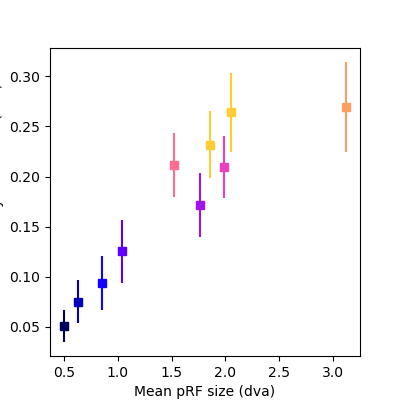

In [18]:
par='ecc'
parid = 1 if par == 'size' else 0

startS,startL=0.25,15
fig,axs=plt.subplots(1,1,figsize=(4,4))

AFS,AFL = widgets.FloatSlider(startS,min=0.1,max=10),\
            widgets.FloatSlider(startL,min=0.1,max=100)

def update_plot(AFS,AFL):
    axs.clear()
    for ix,roi in enumerate(rois):
        axs.errorbar(np.mean(size[ix]),
                    np.mean(attn_func(ecc,sizes[ix],0,AFL)[parid]-attn_func(ecc,sizes[ix],0,AFS)[parid]),
                    yerr=scipy.stats.sem(attn_func(ecc,sizes[ix],0,AFL)[parid]-attn_func(ecc,sizes[ix],0,AFS)[parid]),
                    fmt='s',label=roi,
                    color=settings['cmap'][roi])
        axs.set_ylabel('Mean eccentricity difference (dva)')
        axs.set_xlabel('Mean pRF size (dva)')

_=interact(update_plot,
    AFS=AFS,
    AFL=AFL)


# Old AF model testing: DoG, Norm AF

#### DoG AF

interactive(children=(FloatRangeSlider(value=(0.1, 1.0), description='AFS', max=10.0, min=0.1), FloatRangeSlid…

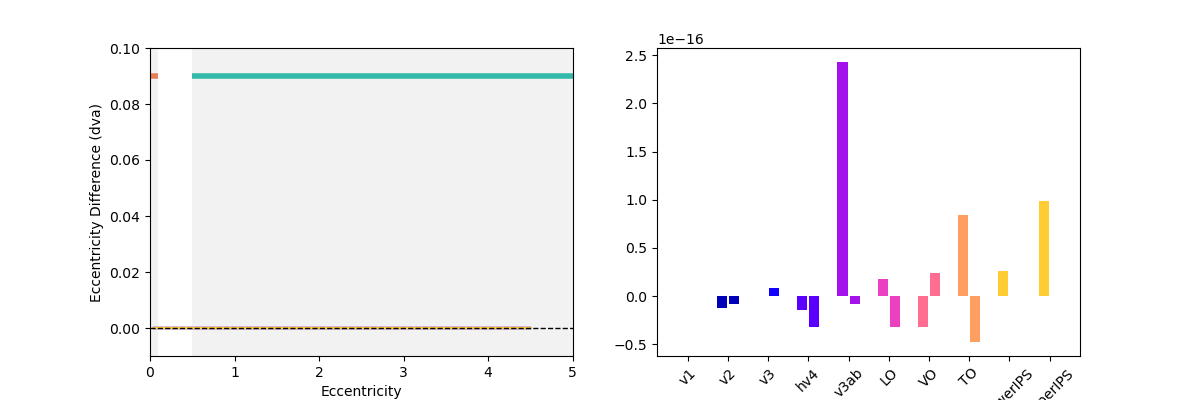

In [30]:
ecc=np.asarray([0.05,0.1,0.15,0.2,0.25,0.35,0.5,1,2,3,4,4.5])
p=roi_sizevecc

attn_func=DoG_attn
b=np.arange(0,5,0.1)
xline=ecc #[(b[i]+b[i+1])/2 for i in range(len(b)-1)]

xbar=np.arange(0,len(roi_sizevecc.keys()),0.5)
rois=[*roi_sizevecc]
sizes=np.asarray([ecc*roi_sizevecc[roi][0]+roi_sizevecc[roi][1] for roi in rois])

startS,startL =[0.1,1],[10,12]
afS,afL,offsetS,offsetL = widgets.FloatRangeSlider(value=startS,min=0.1,max=10),\
                                                    widgets.FloatRangeSlider(value=startL,min=0.1,max=100),\
                                                    widgets.FloatSlider(1,min=1,max=20),\
                                                    widgets.FloatSlider(1,min=1,max=20)
plt.ion()
figure,axs=plt.subplots(1,2,figsize=(12,4),gridspec_kw={'width_ratios': [1,1],'wspace':0.2})

# roi_lines =[]
lines =[]
for ix,roi in enumerate(rois):
    yline=attn_func(ecc,sizes[ix],0,startL)[0]-attn_func(ecc,sizes[ix],0,startS)[0]
    ybar=np.nanmean(attn_func(ecc,sizes[ix],0,startL)[0]-attn_func(ecc,sizes[ix],0,startS)[0])
    ybar=np.ones(len(xbar))
    lines.append(axs[0].plot(xline,yline,color=settings['cmap'][roi],label=roi))
rects=axs[1].bar(xbar,ybar,width=0.25,color='lightgray')

axs[0].set_ylabel('Eccentricity Difference (dva)')
axs[1].set_ylabel('Eccentricity Difference (dva)')

axs[0].set_xlabel('Eccentricity')
axs[0].hlines(0,0,5,'black','dashed',lw=1)
axs[0].set_xlim(0,5)
axs[0].set_ylim(-0.01,0.1)
ylim=axs[0].get_ylim()[1]

axs[0].fill_between([0,0.1],[-ylim,-ylim],[ylim,ylim],alpha=0.1,color='gray',zorder=0,linewidth=0)
axs[0].fill_between([0.5,5],[-ylim,-ylim],[ylim,ylim],alpha=0.1,color='gray',zorder=0,linewidth=0)
axs[0].hlines(ylim-0.01,0,0.1,'black','solid',lw=4,color=settings.get('cmap').get('small'))
axs[0].hlines(ylim-0.01,0.5,5,'black','solid',lw=4,color=settings.get('cmap').get('large'))

def update_plots(AFS,AFL,offsetS,offsetL):
    amp_rngS=[0,0.2]
    amp_rngL=[0.5,5]

    xs=np.arange(0,len(roi_sizevecc.keys()),0.5)
    xs=np.where(xs%1==0,xs,xs-0.2)
    xbar=[xs[i:i+2] for i in range(len(xs)) if i%2 ==0]
    axs[1].clear()

    for ix,roi in enumerate(rois):
        size=sizes[ix]
        for line,rect in zip(lines[ix],rects):
            ylines=attn_func(ecc,size,0,AFL,1,offsetL)[0]-attn_func(ecc,size,0,AFS,1,offsetS)[0]
            line.set_ydata(ylines)
            line.set_color(settings['cmap'][roi])
            # rect.set_height()
        axs[1].bar(xbar[ix],
                [np.mean((attn_func(ecc,size,0,AFL,offsetL,RF_ampL,amp_rngL)[0]-attn_func(ecc,size,0,AFS,offsetS,RF_ampS,amp_rngS)[0])[ecc < 0.3]),
                np.mean((attn_func(ecc,size,0,AFL,offsetL,RF_ampL,amp_rngL)[0]-attn_func(ecc,size,0,AFS,offsetS,RF_ampS,amp_rngS)[0])[ecc >= 0.3])],
                width=0.25,color=settings['cmap'][roi])
    
    axs[1].set_xticks([xbar[i].mean() for i in range(len(xbar))],rois,rotation=45)

fig.tight_layout()
fig.legend()

_=interact(update_plots,
    AFS=afS,
    AFL=afL,
    offsetL=offsetL,
    offsetS=offsetS)


#### Norm pRF x Gaussian AF

interactive(children=(FloatSlider(value=0.1, description='AFS', max=10.0, min=0.1), FloatSlider(value=10.0, de…

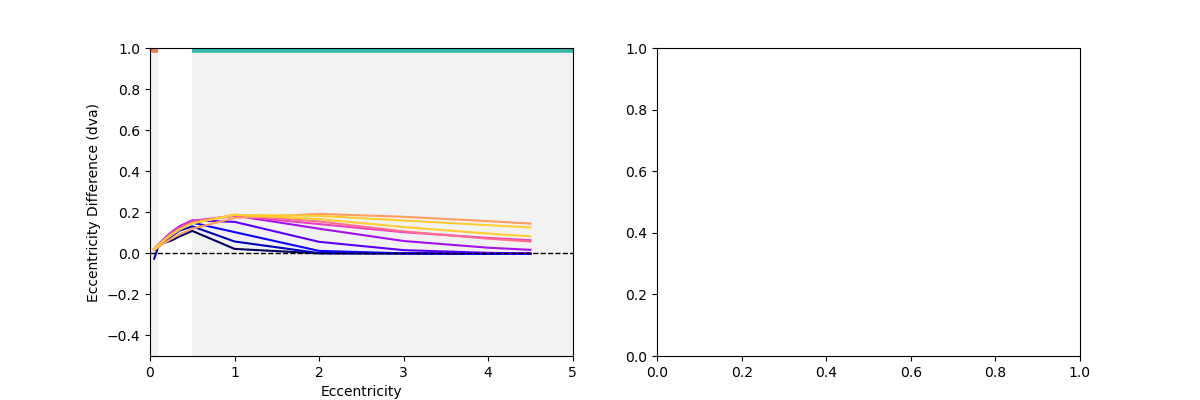

In [27]:
ecc=np.asarray([0.05,0.1,0.15,0.2,0.25,0.35,0.5,1,2,3,4,4.5])
p=roi_sizevecc

attn_func=gaus_attn
b=np.arange(0,5,0.1)
xline=ecc #[(b[i]+b[i+1])/2 for i in range(len(b)-1)]
xbar=np.arange(0,len(roi_sizevecc.keys()),0.5)
rois=[*roi_sizevecc]
sizes=np.asarray([ecc*roi_sizevecc[roi][0]+roi_sizevecc[roi][1] for roi in rois])

startS,startL=0.1,10
afS,afL,offsetS,offsetL,RF_ampS,RF_ampL,szratio = widgets.FloatSlider(startS,min=0.1,max=10),\
                                                    widgets.FloatSlider(startL,min=0.1,max=100),\
                                                    widgets.FloatSlider(1,min=0,max=100),\
                                                    widgets.FloatSlider(1,min=0,max=100),\
                                                    widgets.FloatSlider(1,min=1,max=20),\
                                                    widgets.FloatSlider(1,min=1,max=20),\
                                                    widgets.FloatSlider(2,min=1.1,max=10)

plt.ion()
figure,axs=plt.subplots(1,2,figsize=(12,4),gridspec_kw={'width_ratios': [1,1],'wspace':0.2})

# roi_lines =[]
lines =[]
for ix,roi in enumerate(rois):
    yline=attn_func(ecc,sizes[ix],0,startL)[0]-attn_func(ecc,sizes[ix],0,startS)[0]
    ybar=np.nanmean(attn_func(ecc,sizes[ix],0,startL)[0]-attn_func(ecc,sizes[ix],0,startS)[0])
    ybar=np.ones(len(xbar))
    lines.append(axs[0].plot(xline,yline,color=settings['cmap'][roi],label=roi))
rects=axs[1].bar(xbar,ybar,width=0.25,color='lightgray')

axs[0].set_ylabel('Eccentricity Difference (dva)')
axs[1].set_ylabel('Eccentricity Difference (dva)')

axs[0].set_xlabel('Eccentricity')
axs[0].hlines(0,0,5,'black','dashed',lw=1)
axs[0].set_xlim(0,5)
axs[0].set_ylim(-0.5,1)
ylim=axs[0].get_ylim()[1]

axs[0].fill_between([0,0.1],[-ylim,-ylim],[ylim,ylim],alpha=0.1,color='gray',zorder=0,linewidth=0)
axs[0].fill_between([0.5,5],[-ylim,-ylim],[ylim,ylim],alpha=0.1,color='gray',zorder=0,linewidth=0)
axs[0].hlines(ylim-0.01,0,0.1,'black','solid',lw=4,color=settings.get('cmap').get('small'))
axs[0].hlines(ylim-0.01,0.5,5,'black','solid',lw=4,color=settings.get('cmap').get('large'))

def update_plots(AFS, AFL,offsetS,offsetL,RF_ampL,RF_ampS,szratio):
    amp_rngS=[0,0.2]
    amp_rngL=[0.5,5]

    xs=np.arange(0,len(roi_sizevecc.keys()),0.5)
    xs=np.where(xs%1==0,xs,xs-0.2)
    xbar=[xs[i:i+2] for i in range(len(xs)) if i%2 ==0]
    axs[1].clear()

    for ix,roi in enumerate(rois):
        size=sizes[ix]
        for line,rect in zip(lines[ix],rects):
            ylines=attn_func(ecc,size,0,AFL,offsetL,RF_ampL,amp_rngL,sigSD2=(size*szratio))[0]-attn_func(ecc,size,0,AFS,offsetS,RF_ampS,amp_rngS,sigSD2=(size*szratio))[0]
            # line=line[0]
            line.set_ydata(ylines)
            line.set_color(settings['cmap'][roi])
            # rect.set_height()
        axs[1].bar(xbar[ix],
                [np.mean((attn_func(ecc,size,0,AFL,offsetL,RF_ampL,amp_rngL,sigSD2=size*szratio)[0]-attn_func(ecc,size,0,AFS,offsetS,RF_ampS,amp_rngS,sigSD2=size*szratio)[0])[ecc < 0.3]),
                np.mean((attn_func(ecc,size,0,AFL,offsetL,RF_ampL,amp_rngL,sigSD2=size*szratio)[0]-attn_func(ecc,size,0,AFS,offsetS,RF_ampS,amp_rngS,sigSD2=size*szratio)[0])[ecc >= 0.3])],
                width=0.25,color=settings['cmap'][roi])
    
    axs[1].set_xticks([xbar[i].mean() for i in range(len(xbar))],rois,rotation=45)

fig.tight_layout()
fig.legend()

_=interact(update_plots,
    AFS=afS,
    AFL=afL,
    offsetL=offsetL,
    offsetS=offsetS,
    RF_ampL=RF_ampL,
    RF_ampS=RF_ampS,
    szratio=szratio)


interactive(children=(FloatSlider(value=0.1, description='AFS', max=10.0, min=0.1), FloatSlider(value=10.0, de…

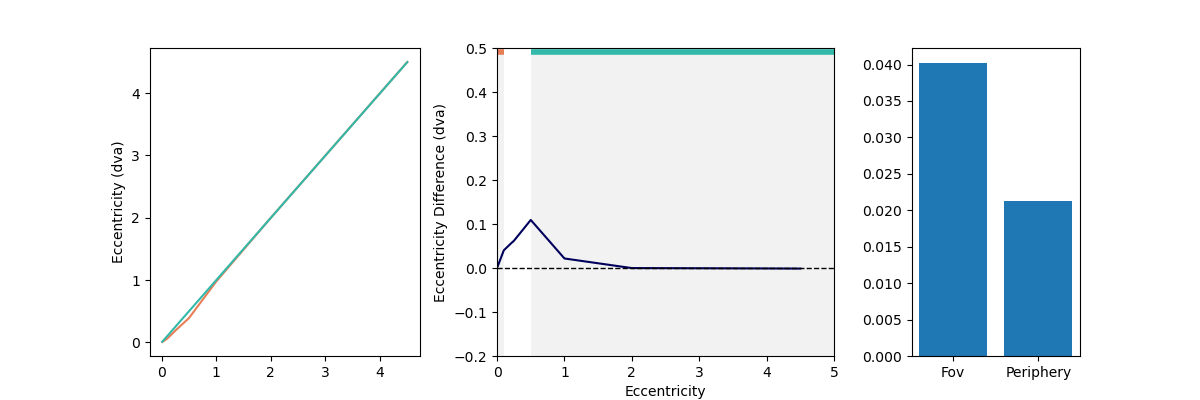

In [163]:
ecc=np.asarray([0.01,0.1,0.2,0.25,0.5,1,2,3,4,4.5])
p=roi_sizevecc
size=ecc*p['v1'][0]+p['v1'][1]

attn_func=gaus_attn
b=np.arange(0,5,0.1)
xline=ecc #[(b[i]+b[i+1])/2 for i in range(len(b)-1)]
xbar=np.arange(len(roi_sizevecc.keys()))

startS,startL=0.1,10
afS,afL,offsetS,offsetL,RF_ampS,RF_ampL,amp_rng,size_roi = widgets.FloatSlider(startS,min=0.1,max=10),\
                                                    widgets.FloatSlider(startL,min=0.1,max=100),\
                                                    widgets.FloatSlider(1,min=0,max=100),\
                                                    widgets.FloatSlider(1,min=0,max=100),\
                                                    widgets.FloatSlider(1,min=1,max=20),\
                                                    widgets.FloatSlider(1,min=1,max=20),\
                                                    widgets.FloatRangeSlider(value=[0,5],min=0,max=5),\
                                                    widgets.Dropdown(options=roi_sizevecc.keys(),value='v1',description='ROI')
plt.ion()
figure,axs=plt.subplots(1,3,figsize=(12,4),gridspec_kw={'width_ratios': [0.8,1,0.5],'wspace':0.3})

lines =[]
ylines=[attn_func(ecc,size,0,startS)[0],attn_func(ecc,size,0,startL)[0],attn_func(ecc,size,0,startL)[0]-attn_func(ecc,size,0,startS)[0]]
ybar=np.nanmean(attn_func(ecc,size,0,startL)[0]-attn_func(ecc,size,0,startS)[0])
lines.append(axs[0].plot(xline,ylines[0],color=settings['cmap']['small'],label=roi))
lines.append(axs[0].plot(xline,ylines[1],color=settings['cmap']['large'],label=roi))
lines.append(axs[1].plot(xline,ylines[2],color=settings['cmap'][roi],label=roi))

axs[0].set_ylabel('Eccentricity (dva)')
axs[1].set_ylabel('Eccentricity Difference (dva)')
axs[2].set_ylabel('Eccentricity Difference (dva)')

axs[1].set_xlabel('Eccentricity')
axs[1].hlines(0,0,5,'black','dashed',lw=1)
axs[1].set_xlim(0,5)
axs[1].set_ylim(-0.2,0.5)
ylim=axs[1].get_ylim()[1]

axs[1].fill_between([0,0.1],[-ylim,-ylim],[ylim,ylim],alpha=0.1,color='gray',zorder=0,linewidth=0)
axs[1].fill_between([0.5,5],[-ylim,-ylim],[ylim,ylim],alpha=0.1,color='gray',zorder=0,linewidth=0)
axs[1].hlines(ylim-0.01,0,0.1,'black','solid',lw=4,color=settings.get('cmap').get('small'))
axs[1].hlines(ylim-0.01,0.5,5,'black','solid',lw=4,color=settings.get('cmap').get('large'))

def sub_eccs(AFS, AFL,offsetS,offsetL,RF_ampL,RF_ampS,amp_rng,size_roi):
    size=ecc*roi_sizevecc[size_roi][0]+roi_sizevecc[size_roi][1]
    cmaps=['small','large',size_roi]
    for i,line in enumerate(lines):
        ylines=[attn_func(ecc,size,0,AFS,offsetS,RF_ampS,amp_rng)[0],\
                attn_func(ecc,size,0,AFL,offsetL,RF_ampL,amp_rng)[0],\
                attn_func(ecc,size,0,AFL,offsetL,RF_ampL,amp_rng)[0]-attn_func(ecc,size,0,AFS,offsetS,RF_ampS,amp_rng)[0]]
        line=line[0]
        line.set_ydata(ylines[i])
        line.set_color(settings['cmap'][cmaps[i]])
    axs[2].clear()
    axs[2].bar([0,1],
               [np.mean((attn_func(ecc,size,0,AFL,offsetL,RF_ampL,amp_rng)[0]-attn_func(ecc,size,0,AFS,offsetS,RF_ampS,amp_rng)[0])[ecc < 0.3]),
                np.mean((attn_func(ecc,size,0,AFL,offsetL,RF_ampL,amp_rng)[0]-attn_func(ecc,size,0,AFS,offsetS,RF_ampS,amp_rng)[0])[ecc >= 0.3])])
    axs[2].set_xticks([0,1],['Fov','Periphery'])

fig.tight_layout()
fig.legend()

_=interact(sub_eccs,
    AFS=afS,
    AFL=afL,
    offsetL=offsetL,
    offsetS=offsetS,
    RF_ampL=RF_ampL,
    RF_ampS=RF_ampS,
    amp_rng=amp_rng,
    size_roi=size_roi
    )

# Fitting AF models to data

In [22]:
from functools import partial

In [69]:
ypts_tot=np.load('eccdiff_per_roi.npy')

if np.ndim(ypts_tot) == 3:
    ypts=ypts_tot
    ypts_tot=np.nanmean(ypts_tot,axis=1) #roi,sub,bin (points from above plot)

tmpypts=ypts_tot[:-2]
ypts_tot=np.vstack((tmpypts,np.nanmean(ypts_tot[-2:,:],axis=0)))

ypts_tot.shape

(9, 20)

In [91]:
a=np.arange(0,5.2,0.25)
x=[(a[i]+a[i+1])/2 for i in range(len(a)-1)]
xx=np.asarray([x]*len(ypts_tot))

sz_ecc=np.asarray([v for k,v in roi_sizevecc.items()])
size_from_ecc = lambda x: (x.T*sz_ecc[:,0] + sz_ecc[:,1]).T
c=np.asarray([v for k,v in settings['cmap'].items()])[-10:]

def AF_diff(xx,sig_S,sig_L,a_S=1,a_L=1,offset_on=True):
    """
    Does direct multiplication of S & L gaussian attention fields by respective RFs, 
    then subtracts eccentricity estimates of L-AF minus S-AF. 
    """
    nrois=9
    
    b=np.linspace(-20,20,100)
    xx=xx.reshape(nrois,-1)
    assert np.ndim(xx) == 2,' must be 2-d'
    assert xx.shape[0] == len(ypts_tot),'first dim must be nROIs'
    mAF=0
    offset=int(offset_on)
    sz_RF = size_from_ecc(xx)
    return np.asarray([gaus_attn(xx[r],sz_RF[r],0,sig_L,offset,scalingAF=a_L)[0]-gaus_attn(xx[r],sz_RF[r],0,sig_S,offset,scalingAF=a_S)[0] for r in range(len(xx))]).reshape(-1)
AF_diff_offset0=partial(AF_diff,a_L=1,a_S=1,offset_on=False)
AF_diff_offset1=partial(AF_diff,offset_on=True)

/Users/sumiyaabdirashid/miniconda3/envs/cortexenv/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


In [77]:
xx[:,3:].shape
ypts_tot[:,:-3].shape

(9, 17)

In [101]:
# offset = 0
y=ypts_tot[:,3:].reshape(-1)
y/=y.max() 
popt0,pcov0=scipy.optimize.curve_fit(AF_diff_offset0,xx[:,3:].flatten(),ypts_tot[:,:-3].reshape(-1),bounds=((0,0),(np.inf,np.inf)))
print(popt0,pcov0)

[2.71192232 4.2006312 ] [[0.05122611 0.09348994]
 [0.09348994 0.18158393]]


In [114]:
# offset = 1
y=ypts_tot[:,5:].reshape(-1)
y/=y.max()
popt,pcov=scipy.optimize.curve_fit(AF_diff_offset1,xx[:,5:],y,bounds=((0,0,-np.inf,-np.inf),(np.inf,np.inf,np.inf,np.inf)))
print(popt,pcov)

[ 1.18739339  1.65615741  0.47562587 -1.25433593] [[ 0.14220066 -0.05785555 -0.03493811 -0.03514024]
 [-0.05785555  0.04696036  0.02129751  0.01134696]
 [-0.03493811  0.02129751  0.04724484  0.0423062 ]
 [-0.03514024  0.01134696  0.0423062   0.04484557]]


In [115]:
a=np.arange(0,10.2,0.25)
x_extend=[(a[i]+a[i+1])/2 for i in range(len(a)-1)]
xx_extend=np.asarray([x_extend]*10)[:,4:24]

In [36]:
xx_extend

(10, 20)

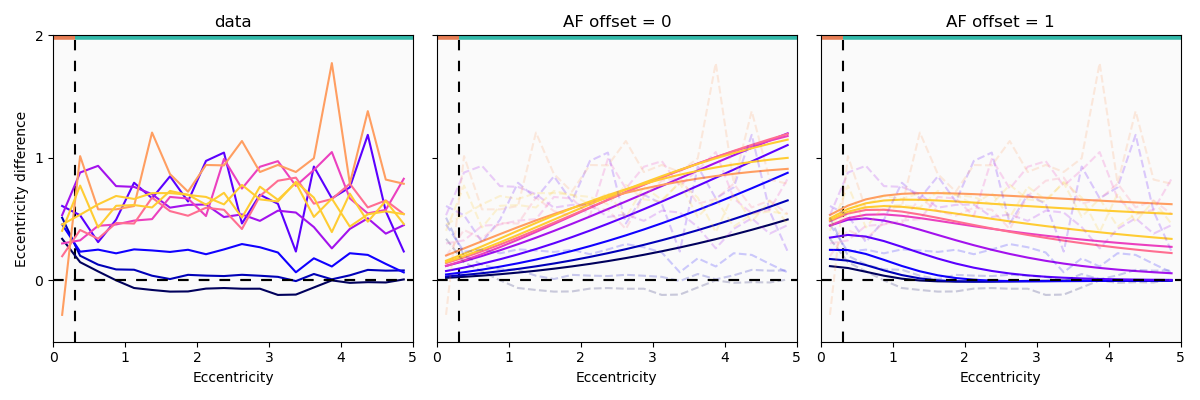

In [31]:
# popt0=[2.5,3.8] #[2.3848323, 3.5751067]
# popt=[0.45403141, 2.18033736, 1.30148777, -0.67141943,]#[ 0.89330367,  2.02829751,  2.63364313, -0.01563488]

ax3,ax1,ax2=0,1,2

fig,axs=plt.subplots(1,3,figsize=(12,4),sharex=True,sharey=True)#,gridspec_kw={'whitespace': 0.1})

[axs[ax3].plot(xx[i],ypts_tot[i],c=c[i],label=rois[i],alpha=1) for i in range(len(xx))]
axs[ax3].set_title('data')
axs[ax3].set_ylabel('Eccentricity difference')


res0=AF_diff(xx_extend, *popt0,1,1,offset_on=False).reshape(10,20)
[axs[ax1].plot(xx[i],res0[i],c=c[i]) for i in range(len(xx))]
[axs[ax1].plot(xx[i],ypts_tot[i],'--',c=c[i],alpha=0.2) for i in range(len(xx))]
axs[ax1].set_title('AF offset = 0')

res1=AF_diff(xx_extend, *popt,offset_on=True).reshape(10,20)
[axs[ax2].plot(xx[i],res1[i],c=c[i]) for i in range(len(xx))]
[axs[ax2].plot(xx[i],ypts_tot[i],'--',c=c[i],alpha=0.2) for i in range(len(xx))]
axs[ax2].set_title('AF offset = 1')

for ax in axs.flatten():
    ax.hlines(0,0,5,'black',linestyles=(0,(5,5)))
    # plotting.conform_ax_to_obj(ax)
    ecc_pl_format(ax,s_stim=[0,0.3],l_stim=[0.3,5],vline=True,xlim=[0,5],ylim=[-0.5,2])
    # ax.set_ylabel('Eccentricity difference')
    ax.set_xlabel('Eccentricity')
    ax.set_yticks([0,1,2])
fig.tight_layout()